In [1]:
import reskit as rk
import pandas as pd
import numpy as np

This script illustrates how to run a simulation with ETHOS.RESKit.Wind.

## Preparations
In ETHOS.RESKit.Wind one can simulate each wind turbine individually with its own characteristics.
If you know the turbine model and it is included in RESKit, you can use the actual power curve of the turbines. Otherwise RESKit will create a synthetic power curve for you.
The following specifications need to be given by the user:
- latitude
- longitute
- hub height [m]
- capacity [kW]
- rotor diameter [m] (or power curve)

These specifications are given in the form of a pandas DataFrame.

In [2]:
# Create Placements DataFrame with turbine locations and specifications

placements = pd.DataFrame(
    {
        "lon": [5.985195, 5.994685, 6.004750],
        "lat": [50.797254, 50.794208, 50.784432],
        "hub_height": [120, 120, 82],
        "capacity": [4000, 4000, 4000],
        "rotor_diam": [130, 150, 136],
        "powerCurve": [np.nan, np.nan, "V117-3300"],
    }
)
placements

,lon,lat,hub_height,capacity,rotor_diam,powerCurve
0,5.985195,50.797254,120,4000,130,NaN
1,5.994685,50.794208,120,4000,150,NaN
2,6.004750,50.784432,82,4000,136,V117-3300


# Run the simulation workflow
RESKit will run the simulation and create an xarray Dataset with the simulation results for you.
Apart from the capacity_factor, RESKit also includes the turbine specifications and intermediate data used to determine the capacity factor (such as wind speeds, surface pressure etc.)

In [3]:
reskit_xr = rk.wind.wind_era5_PenaSanchezDunkelWinklerEtAl2025(
    placements=placements,
    era5_path=rk.TEST_DATA["era5-like"],
    gwa_100m_path=rk.TEST_DATA["gwa100-like.tif"],
    esa_cci_path=rk.TEST_DATA["ESA_CCI_2018_clip.tif"],
)
reskit_xr

2025-01-24 15:27:06.983837 Now extracting correction factors for a total of 3 placements from /fast/home/p-dunkel/RESKit_publication/RESKit/reskit/wind/core/data/cf_correction_factors_PSDW2025.tif:
2025-01-24 15:27:06.987977 Based on max_batch_size=3, the total of 3 placements were split into 1 sub batches. Proceeding with batch 1/1 (id=0) with 3 placements.
2025-01-24 15:27:06.992949 Maximum rel. deviation after initial simulation is 0.1582, Number/share of placements with deviation > tolerance (0.01): 3/3. More iterations required.
2025-01-24 15:27:06.995248 Maximum rel. deviation after 1 additional iteration(s) is 0.0458, Number/share of placements with deviation > tolerance (0.01): 3/3. More iterations required.
2025-01-24 15:27:06.997422 Maximum rel. deviation after 2 additional iteration(s) is 0.0135, Number/share of placements with deviation > tolerance (0.01): 1/3. More iterations required.
2025-01-24 15:27:06.998907 Required tolerance of 0.01 reached after 3 additional iterati

<xarray.Dataset> Size: 18kB
Dimensions:                         (location: 3, time: 140)
Coordinates:
  * location                        (location) int64 24B 0 1 2
  * time                            (time) datetime64[ns] 1kB 2014-12-31T23:3...
Data variables: (12/13)
    lon                             (location) float64 24B 5.985 5.995 6.005
    lat                             (location) float64 24B 50.8 50.79 50.78
    hub_height                      (location) int64 24B 120 120 82
    capacity                        (location) int64 24B 4000 4000 4000
    rotor_diam                      (location) int64 24B 130 150 136
    powerCurve                      (location) object 24B 'SPC:301,25' ... 'V...
    ...                              ...
    roughness                       (location) float64 24B 0.1 0.03 0.03
    elevated_wind_speed             (time, location) float64 3kB 4.291 ... 6.992
    surface_pressure                (time, location) float64 3kB 1.013e+05 .....
    surface_air_temperature         (time, location) float64 3kB 0.01979 ... ...
    boundary_layer_height           (time, location) float64 3kB 120.4 ... 346.5
    capacity_factor                 (time, location) float64 3kB 0.04508 ... ...

RESKit will output the capacity factor of each location for every hour of the simulated year.

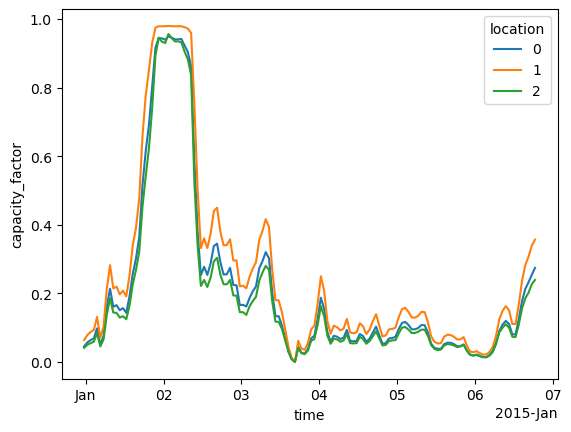

In [4]:
reskit_xr["capacity_factor"].isel(time=slice(0, 400)).plot.line(x="time")